/tmp/ipython-input-4-3278287607.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['genre_filled'] = final_df['genre_filled'].str.lower().str.strip()
/tmp/ipython-input-4-3278287607.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=genre_counts.index[:20], x=genre_counts.values[:20], palette='viridis')


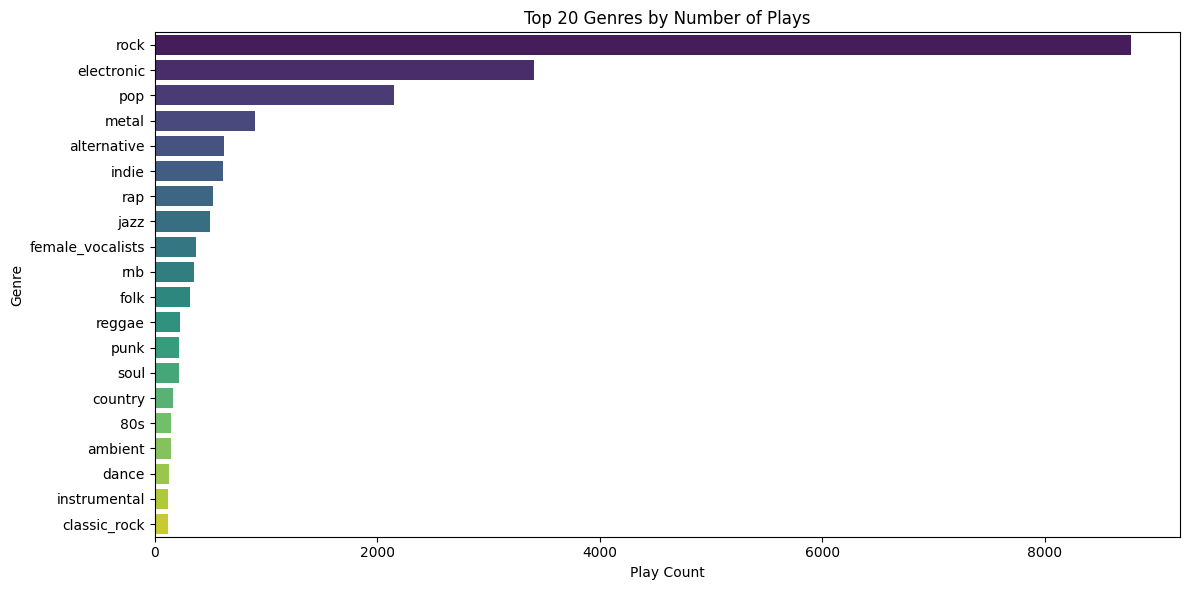

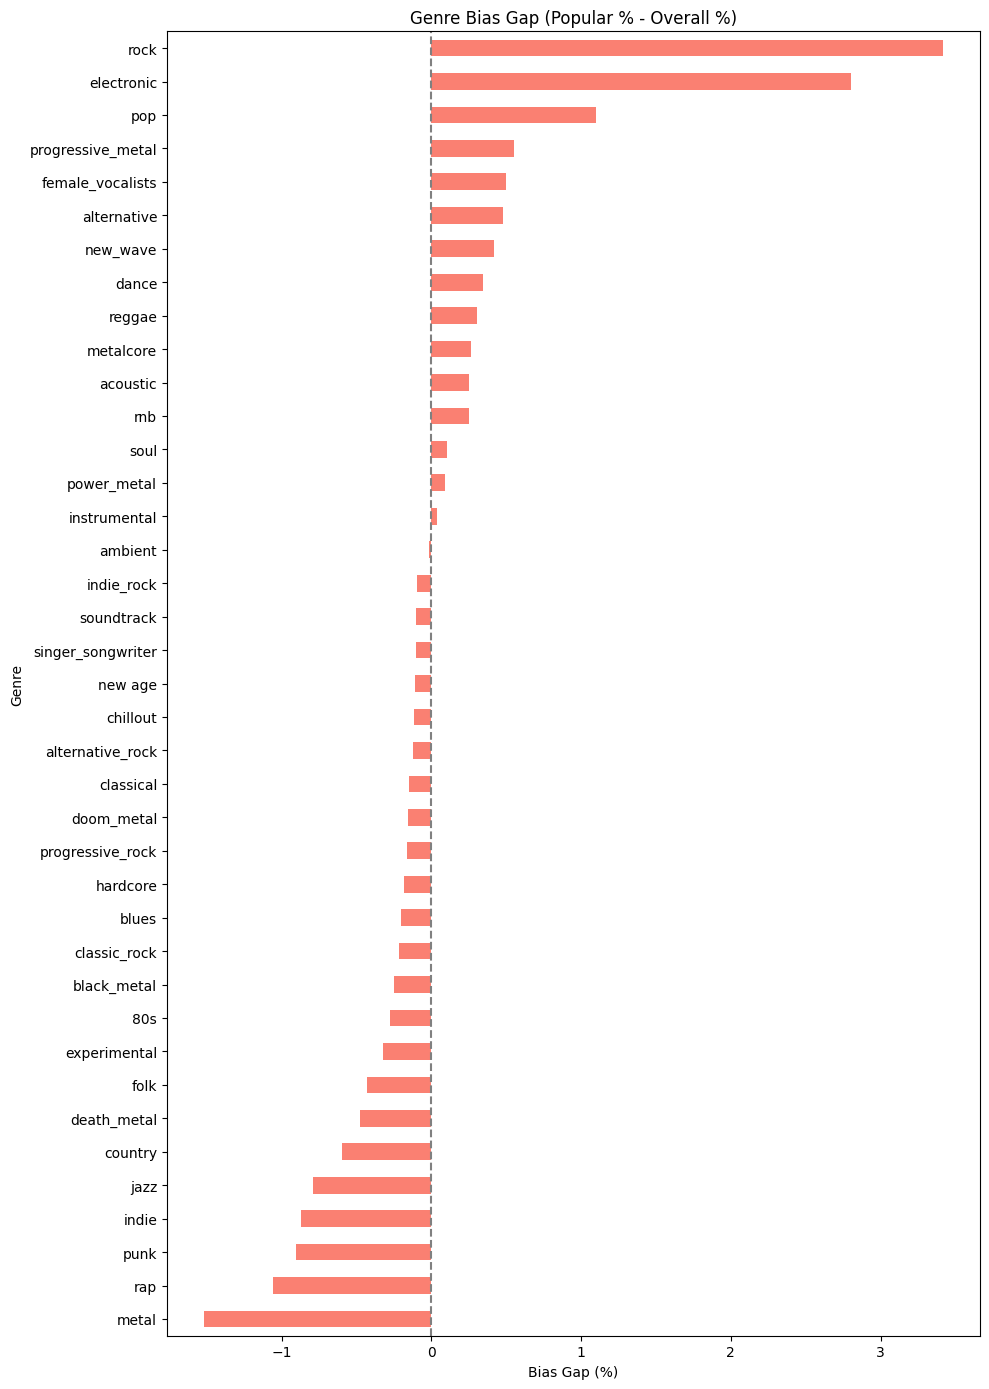

In [ ]:
# Music Genre Analysis (Last.fm + Spotify Metadata)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
lastfm_df = pd.read_csv("Last.fm_data.csv")
music_info_df = pd.read_csv("Music Info.csv")

# Normalize artist and track names for merging
lastfm_df['Artist_norm'] = lastfm_df['Artist'].str.lower().str.strip()
lastfm_df['Track_norm'] = lastfm_df['Track'].str.lower().str.strip()
music_info_df['artist_norm'] = music_info_df['artist'].str.lower().str.strip()
music_info_df['name_norm'] = music_info_df['name'].str.lower().str.strip()

# Merge datasets
merged_df = pd.merge(
    lastfm_df,
    music_info_df,
    left_on=['Artist_norm', 'Track_norm'],
    right_on=['artist_norm', 'name_norm'],
    how='inner'
)

# Fill missing genre using tags (take first tag)
def extract_primary_tag(tags):
    if pd.isna(tags):
        return None
    tag_list = [tag.strip() for tag in tags.split(',')]
    return tag_list[0] if tag_list else None

merged_df['genre_filled'] = merged_df['genre']
merged_df.loc[merged_df['genre_filled'].isna(), 'genre_filled'] = merged_df.loc[
    merged_df['genre_filled'].isna(), 'tags'
].apply(extract_primary_tag)

# Filter to records with known genre
final_df = merged_df.dropna(subset=['genre_filled'])

# --- Genre Distribution (normalized) ---
# Normalize genre names to lowercase to avoid duplicates like 'Rock' vs 'rock'
final_df['genre_filled'] = final_df['genre_filled'].str.lower().str.strip()

# Count genres after normalization
genre_counts = final_df['genre_filled'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(y=genre_counts.index[:20], x=genre_counts.values[:20], palette='viridis')
plt.title("Top 20 Genres by Number of Plays")
plt.xlabel("Play Count")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# --- Popularity Bias Analysis ---
# Count how often each track was played
track_popularity = final_df.groupby(['Artist', 'Track'])['Username'].count().reset_index(name='PlayCount')

# Merge back to get genres
final_df = pd.merge(final_df, track_popularity, on=['Artist', 'Track'])

# Define Popular vs Non-Popular using 75th percentile threshold
popularity_threshold = final_df['PlayCount'].quantile(0.75)
final_df['Popularity'] = final_df['PlayCount'].apply(lambda x: 'Popular' if x >= popularity_threshold else 'Non-Popular')

# Genre distribution comparison
overall_genre = final_df['genre_filled'].value_counts()
popular_genre = final_df[final_df['Popularity'] == 'Popular']['genre_filled'].value_counts()

genre_bias_df = pd.DataFrame({
    'Overall': overall_genre,
    'Popular': popular_genre
}).fillna(0)

genre_bias_df['Overall %'] = genre_bias_df['Overall'] / genre_bias_df['Overall'].sum() * 100
genre_bias_df['Popular %'] = genre_bias_df['Popular'] / genre_bias_df['Popular'].sum() * 100
genre_bias_df['Bias Gap (%)'] = genre_bias_df['Popular %'] - genre_bias_df['Overall %']

# Filter out genres with very low occurrence to clean up the plot
min_genre_plays = 20  # You can increase this if the plot still looks crowded
valid_genres = genre_bias_df[genre_bias_df['Overall'] >= min_genre_plays]

# Plot cleaned Genre Bias Gap
plt.figure(figsize=(10, 14))
valid_genres.sort_values('Bias Gap (%)')['Bias Gap (%)'].plot(kind='barh', color='salmon')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Genre Bias Gap (Popular % - Overall %)")
plt.xlabel("Bias Gap (%)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()



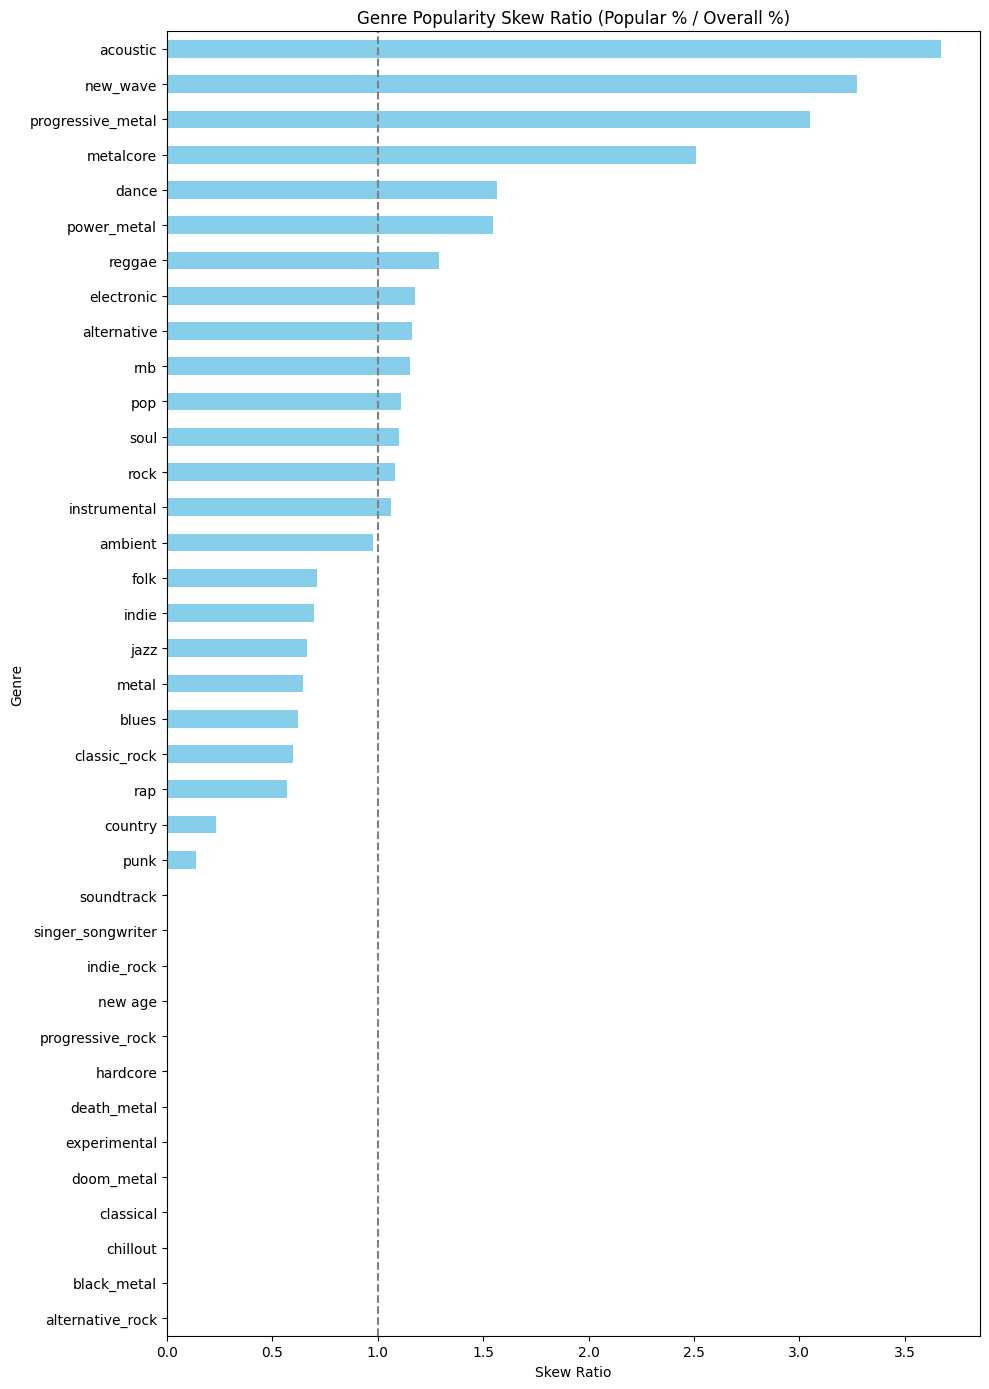

In [ ]:
# Step 1: Normalize genres (if not done already)
final_df['genre_filled'] = final_df['genre_filled'].str.lower().str.strip()

# Step 2: Filter noisy/unwanted genres
drop_list = ['mb', 'female_vocalists', 'male_vocalists', '80s', '90s']
final_df = final_df[~final_df['genre_filled'].isin(drop_list)]

# Step 3: Recompute overall and popular genre % from cleaned data
overall_genre = final_df['genre_filled'].value_counts()
popular_genre = final_df[final_df['Popularity'] == 'Popular']['genre_filled'].value_counts()

genre_bias_df = pd.DataFrame({
    'Overall': overall_genre,
    'Popular': popular_genre
}).fillna(0)

genre_bias_df['Overall %'] = genre_bias_df['Overall'] / genre_bias_df['Overall'].sum() * 100
genre_bias_df['Popular %'] = genre_bias_df['Popular'] / genre_bias_df['Popular'].sum() * 100
genre_bias_df['Bias Gap (%)'] = genre_bias_df['Popular %'] - genre_bias_df['Overall %']

# Step 4: Filter out rare genres again
min_genre_plays = 20
valid_skew_df = genre_bias_df[genre_bias_df['Overall'] >= min_genre_plays].copy()

# Step 5: Compute skew safely
valid_skew_df['Skew Ratio'] = valid_skew_df['Popular %'] / valid_skew_df['Overall %']

# Step 6: Plot cleaned skew ratio
plt.figure(figsize=(10, 14))
valid_skew_df.sort_values('Skew Ratio')['Skew Ratio'].plot(kind='barh', color='skyblue')
plt.axvline(1, color='gray', linestyle='--')
plt.title("Genre Popularity Skew Ratio (Popular % / Overall %)")
plt.xlabel("Skew Ratio")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


In [ ]:
# Sort and display top 10 over- and underrepresented genres
top_skewed = valid_skew_df.sort_values('Skew Ratio', ascending=False).head(10)
bottom_skewed = valid_skew_df.sort_values('Skew Ratio').head(10)

print("Top 10 Overrepresented Genres (Popular % / Overall %):")
display(top_skewed[['Skew Ratio', 'Popular %', 'Overall %']])

print("\nTop 10 Underrepresented Genres:")
display(bottom_skewed[['Skew Ratio', 'Popular %', 'Overall %']])


Top 10 Overrepresented Genres (Popular % / Overall %):


,Skew Ratio,Popular %,Overall %
genre_filled,,,
acoustic,3.673310,0.355872,0.096880
new_wave,3.271774,0.618093,0.188917
progressive_metal,3.052612,0.842854,0.276109
metalcore,2.508092,0.449522,0.179229
dance,1.564366,0.992695,0.634567
power_metal,1.546657,0.262221,0.169541
reggae,1.288881,1.404757,1.089905
electronic,1.176113,19.404383,16.498741
alternative,1.164950,3.521259,3.022670



Top 10 Underrepresented Genres:


,Skew Ratio,Popular %,Overall %
genre_filled,,,
alternative_rock,0.0,0.0,0.125945
black_metal,0.0,0.0,0.256733
chillout,0.0,0.0,0.121101
classical,0.0,0.0,0.155009
doom_metal,0.0,0.0,0.159853
experimental,0.0,0.0,0.329394
death_metal,0.0,0.0,0.489246
hardcore,0.0,0.0,0.188917
progressive_rock,0.0,0.0,0.164697


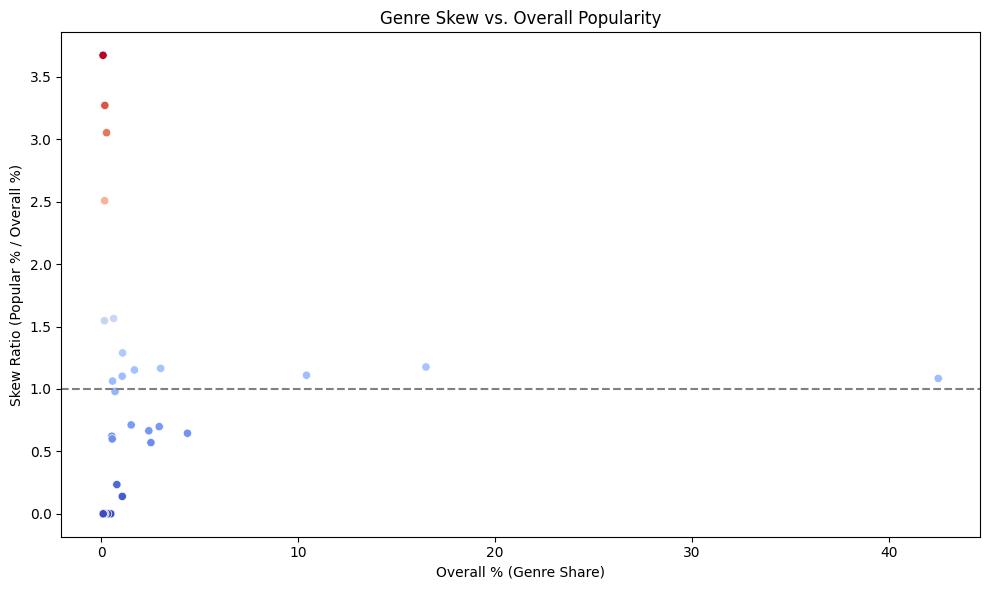

In [ ]:
# Scatter plot to show skew vs. frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=valid_skew_df,
    x='Overall %',
    y='Skew Ratio',
    hue='Skew Ratio',
    palette='coolwarm',
    legend=False
)
plt.axhline(1, linestyle='--', color='gray')
plt.title("Genre Skew vs. Overall Popularity")
plt.xlabel("Overall % (Genre Share)")
plt.ylabel("Skew Ratio (Popular % / Overall %)")
plt.tight_layout()
plt.show()


In [ ]:
# Reuse final_df and apply your cleaned genre
final_df['genre_cleaned'] = final_df['genre_filled'].str.lower().str.strip()
final_df = final_df[~final_df['genre_cleaned'].isin(['mb', 'female_vocalists', '80s', '90s'])]

# Save interaction data
interaction_df = final_df[['Username', 'Track', 'Time']]
interaction_df.columns = ['UserID', 'ItemID', 'Timestamp']
interaction_df.to_csv("music_interaction.csv", index=False)

# Save user data
user_df = interaction_df[['UserID']].drop_duplicates()
user_df.to_csv("music_user.csv", index=False)

# Save item data
item_df = final_df[['Track', 'Artist', 'genre_cleaned']].drop_duplicates()
item_df.columns = ['ItemID', 'Artist', 'Genre']
item_df.to_csv("music_item.csv", index=False)


In [ ]:
import os
import pandas as pd

# Use the final_df you already cleaned
# final_df must have: Username, Track, Artist, Time, genre_cleaned

# Create interaction DataFrame for RecBole
interaction_df = final_df[['Username', 'Track', 'Time']]
interaction_df.columns = ['UserID', 'ItemID', 'Timestamp']

# Create user DataFrame
user_df = interaction_df[['UserID']].drop_duplicates()

# Create item (track) DataFrame
item_df = final_df[['Track', 'Artist', 'genre_cleaned']].drop_duplicates()
item_df.columns = ['ItemID', 'Artist', 'Genre']

# Ensure output directory exists
os.makedirs('./output/', exist_ok=True)

# Save CSVs for RecBole
interaction_df.to_csv('./output/music_interaction.csv', index=False)
user_df.to_csv('./output/music_user.csv', index=False)
item_df.to_csv('./output/music_item.csv', index=False)

# Preview
print(interaction_df.head())
print(user_df.head())
print(item_df.head())


    UserID             ItemID Timestamp
0  Babs_05          Big Ego's     11:54
1  Babs_05  Where Is The Love     17:21
2  Babs_05   Rhapsody in Blue     14:47
3  Babs_05       Them Changes     15:19
5  Babs_05      Talk Is Cheap     15:04
           UserID
0         Babs_05
4381     franhale
8825       eartle
11464  massdosage
13606  Knapster01
              ItemID           Artist       Genre
0          Big Ego's          Dr. Dre         rap
1  Where Is The Love    Damian Marley      reggae
2   Rhapsody in Blue  George Gershwin        jazz
3       Them Changes       Thundercat  electronic
5      Talk Is Cheap       Chet Faker  electronic


In [ ]:
!pip install numpy==1.24.4
!pip install tensorboard==2.12.3
!pip install recbole


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.4.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.2
    Uninstalling google-auth-oauthlib-1.2.2:
      Successfully uninstalled google-auth-oauthlib-1.2.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.12.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 16.0 MB/s eta 0:00:00
   ━

In [ ]:
pip uninstall tensorflow

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.18.0


In [ ]:
pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 24.7 MB/s eta 0:00:

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
# Try importing the necessary libraries
import recbole
import numpy as np
import tensorflow as tf
import tensorboard

In [ ]:
# Print the versions to verify installation
print("RecBole version:", recbole.__version__)
print("Numpy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("TensorBoard version:", tensorboard.__version__)


RecBole version: 1.2.1
Numpy version: 1.23.5
TensorFlow version: 2.12.0
TensorBoard version: 2.12.3


In [ ]:
import pandas as pd

# Load your merged data
lastfm_df = pd.read_csv("Last.fm_data.csv")
music_info_df = pd.read_csv("Music Info.csv")

# Normalize artist and track names
lastfm_df['Artist_norm'] = lastfm_df['Artist'].str.lower().str.strip()
lastfm_df['Track_norm'] = lastfm_df['Track'].str.lower().str.strip()
music_info_df['artist_norm'] = music_info_df['artist'].str.lower().str.strip()
music_info_df['name_norm'] = music_info_df['name'].str.lower().str.strip()

# Merge datasets
merged_df = pd.merge(
    lastfm_df,
    music_info_df,
    left_on=['Artist_norm', 'Track_norm'],
    right_on=['artist_norm', 'name_norm'],
    how='inner'
)

# Fill missing genres
def extract_primary_tag(tags):
    if pd.isna(tags):
        return None
    tag_list = [tag.strip() for tag in tags.split(',')]
    return tag_list[0] if tag_list else None

merged_df['genre_filled'] = merged_df['genre']
merged_df.loc[merged_df['genre_filled'].isna(), 'genre_filled'] = merged_df.loc[
    merged_df['genre_filled'].isna(), 'tags'
].apply(extract_primary_tag)

# Final genre cleaning
final_df = merged_df.dropna(subset=['genre_filled'])
final_df['genre_cleaned'] = final_df['genre_filled'].str.lower().str.strip()
final_df = final_df[~final_df['genre_cleaned'].isin(['mb', 'female_vocalists', '80s', '90s'])]


/tmp/ipython-input-3-834198585.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['genre_cleaned'] = final_df['genre_filled'].str.lower().str.strip()


In [ ]:
import os

# Create interaction DataFrame for RecBole
interaction_df = final_df[['Username', 'Track', 'Time']]
interaction_df.columns = ['UserID', 'ItemID', 'Timestamp']

# Create user DataFrame
user_df = interaction_df[['UserID']].drop_duplicates()

# Create item (track) DataFrame
item_df = final_df[['Track', 'Artist', 'genre_cleaned']].drop_duplicates()
item_df.columns = ['ItemID', 'Artist', 'Genre']

# Ensure output directory exists
os.makedirs('./output/', exist_ok=True)

# Save CSVs for RecBole
interaction_df.to_csv('./output/music_interaction.csv', index=False)
user_df.to_csv('./output/music_user.csv', index=False)
item_df.to_csv('./output/music_item.csv', index=False)

# Preview
print(interaction_df.head())
print(user_df.head())
print(item_df.head())


    UserID             ItemID Timestamp
0  Babs_05          Big Ego's     11:54
1  Babs_05  Where Is The Love     17:21
2  Babs_05   Rhapsody in Blue     14:47
3  Babs_05       Them Changes     15:19
5  Babs_05      Talk Is Cheap     15:04
           UserID
0         Babs_05
4389     franhale
8837       eartle
11478  massdosage
13623  Knapster01
              ItemID           Artist       Genre
0          Big Ego's          Dr. Dre         rap
1  Where Is The Love    Damian Marley      reggae
2   Rhapsody in Blue  George Gershwin        jazz
3       Them Changes       Thundercat  electronic
5      Talk Is Cheap       Chet Faker  electronic


In [ ]:
import pandas as pd

# Drop the timestamp column
df = pd.read_csv("music_interaction.csv")
df = df[['UserID', 'ItemID']]
df.to_csv("music_interaction.csv", index=False)


In [ ]:
import os

# Ensure output directory exists
os.makedirs("output", exist_ok=True)

# Add headers and save .recbole files
def add_recbole_header(file_path, header, output_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    with open(output_path, 'w') as f:
        f.write(header + '\n')
        f.writelines(lines[1:])  # skip existing header

# Interaction file (no timestamp)
add_recbole_header("music_interaction.csv", "UserID:token,ItemID:token", "output/output.inter")
add_recbole_header("music_user.csv", "UserID:token", "output/output.user")
add_recbole_header("music_item.csv", "ItemID:token,Artist:token,Genre:token", "output/output.item")


In [ ]:
yaml_config = """
dataset: output
data_path: ./


USER_ID_FIELD: UserID
ITEM_ID_FIELD: ItemID

load_col:
    inter: [UserID, ItemID]
    user: [UserID]
    item: [ItemID, Artist, Genre]

field_separator: ","
metrics: ["Recall", "Precision", "NDCG", "MRR"]
topk: 10

eval_args:
    split: {'RS': [0.8, 0.1, 0.1]}
    order: RO
    mode: full
"""
with open("recbole_config.yaml", "w") as f:
    f.write(yaml_config)


In [ ]:
import torch

# Patch torch.load globally for RecBole
original_torch_load = torch.load

def patched_load(*args, **kwargs):
    kwargs['weights_only'] = False  # Force this off for compatibility
    return original_torch_load(*args, **kwargs)

torch.load = patched_load


In [ ]:
from recbole.quick_start import run_recbole

run_recbole(model='BPR', config_file_list=['recbole_config.yaml'])


/usr/local/lib/python3.11/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
Train     0:   0%|                                                            | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/recbole/trainer/trainer.py:235: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=self.enable_scaler)
Evaluate   : 1

{'best_valid_score': 1.0,
 'valid_score_bigger': True,
 'best_valid_result': OrderedDict([('recall@10', 0.1769),
              ('precision@10', 0.8),
              ('ndcg@10', 0.8537),
              ('mrr@10', 1.0)]),
 'test_result': OrderedDict([('recall@10', 0.2732),
              ('precision@10', 0.9091),
              ('ndcg@10', 0.9599),
              ('mrr@10', 1.0)])}

In [ ]:
import pandas as pd

user_df = pd.read_csv("music_user.csv")
print(user_df['UserID'].unique()[:10])  # Print first 10 user IDs


['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 'isaac' 'lobsterclaw' 'jajo' 'mremond']


In [ ]:
import pandas as pd

user_df = pd.read_csv("music_user.csv")
print(user_df.head())  # See what the actual UserIDs look like


       UserID
0     Babs_05
1    franhale
2      eartle
3  massdosage
4  Knapster01


In [ ]:
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.general_recommender import BPR  # or your chosen model
from recbole.trainer import Trainer

# Load config
config = Config(model='BPR', config_file_list=['recbole_config.yaml'])

# Create dataset
dataset = create_dataset(config)

# Build train/valid/test dataloaders
train_data, valid_data, test_data = data_preparation(config, dataset)


/usr/local/lib/python3.11/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)


In [ ]:
usernames = ['Babs_05', 'franhale', 'eartle']
internal_ids = dataset.token2id(dataset.uid_field, usernames)
print(dict(zip(usernames, internal_ids)))


{'Babs_05': 1, 'franhale': 2, 'eartle': 3}


In [ ]:
from recbole.model.general_recommender import BPR  # or the model you're using
from recbole.trainer import Trainer

# Create the model
model = BPR(config, train_data.dataset).to(config['device'])

# Train the model
trainer = Trainer(config, model)
best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)


/usr/local/lib/python3.11/dist-packages/recbole/trainer/trainer.py:235: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=self.enable_scaler)


In [ ]:
real_user = 'Babs_05'  # Your actual username from the dataset
internal_user_id = dataset.token2id(dataset.uid_field, [real_user])[0]
print(f"Real UserID: {real_user} -> Internal ID: {internal_user_id}")


Real UserID: Babs_05 -> Internal ID: 1


In [ ]:
from recbole.data.interaction import Interaction

model.eval()

# Prepare tensors
user_id_tensor = torch.tensor([internal_user_id]).to(config['device'])
item_ids = torch.arange(dataset.item_num).to(config['device'])
user_ids = user_id_tensor.repeat(dataset.item_num)

# Combine into RecBole Interaction object
interaction = Interaction({
    config['USER_ID_FIELD']: user_ids,
    config['ITEM_ID_FIELD']: item_ids
})

# Predict scores
with torch.no_grad():
    scores = model.predict(interaction)

# Top-K items
top_k = torch.topk(scores, k=10)
top_item_indices = top_k.indices.cpu().numpy()
top_scores = top_k.values.cpu().numpy()

# Convert internal IDs to real ItemIDs (track names)
recommended_items = dataset.id2token(dataset.iid_field, top_item_indices)

# Display
print(f"\n🎧 Top 10 Recommendations for '{real_user}':")
for rank, (item, score) in enumerate(zip(recommended_items, top_scores), start=1):
    print(f"{rank}. {item} (score: {score:.4f})")



🎧 Top 10 Recommendations for 'Babs_05':
1. California Dreamin' (score: 3.9590)
2. Alison (score: 3.6258)
3. Knowing Me, Knowing You (score: 3.1045)
4. Young Adult Friction (score: 3.0229)
5. Love Will Tear Us Apart (score: 3.0026)
6. Beware (score: 2.9543)
7. Birdland (score: 2.9458)
8. Flashing Lights (score: 2.9358)
9. Tears in the Typing Pool (score: 2.9306)
10. David Watts (score: 2.9232)


In [ ]:
user_tokens_raw = dataset.inter_feat[config['USER_ID_FIELD']].unique()

print("Sample user token raw values:")
for i in range(5):
    print(f"{i}: {user_tokens_raw[i]} (type: {type(user_tokens_raw[i])})")


Sample user token raw values:
0: 1 (type: <class 'torch.Tensor'>)
1: 2 (type: <class 'torch.Tensor'>)
2: 3 (type: <class 'torch.Tensor'>)
3: 4 (type: <class 'torch.Tensor'>)
4: 5 (type: <class 'torch.Tensor'>)


In [ ]:
from recbole.data.interaction import Interaction
from tqdm import tqdm

# Step 1: Get real UserIDs (not tensors)
user_id_map = dataset.id2token(config['USER_ID_FIELD'], list(range(dataset.user_num)))
user_tokens = list(user_id_map)


# Step 2: Prepare item IDs
item_ids = torch.arange(dataset.item_num).to(config['device'])
results = []

print("🔁 Generating recommendations for all users...")
model.eval()

for user_token in tqdm(user_tokens):
    # Convert to internal RecBole ID
    internal_uid = dataset.token2id(dataset.uid_field, [user_token])[0]
    user_ids = torch.tensor([internal_uid] * dataset.item_num).to(config['device'])

    # Create RecBole interaction
    interaction = Interaction({
        config['USER_ID_FIELD']: user_ids,
        config['ITEM_ID_FIELD']: item_ids
    })

    # Predict
    with torch.no_grad():
        scores = model.predict(interaction)

    # Top 10 items
    top_k = torch.topk(scores, k=10)
    top_indices = top_k.indices.cpu().numpy()
    top_scores = top_k.values.cpu().numpy()
    top_items = dataset.id2token(dataset.iid_field, top_indices)

    for item, score in zip(top_items, top_scores):
        results.append({
            'UserID': user_token,
            'ItemID': item,
            'Score': round(float(score), 4)
        })


🔁 Generating recommendations for all users...


100%|██████████| 12/12 [00:00<00:00, 136.95it/s]


In [ ]:
# Convert to DataFrame
rec_df = pd.DataFrame(results)

# Load metadata with Genre, Artist, etc.
item_meta = pd.read_csv("music_item.csv")
rec_df = pd.merge(rec_df, item_meta, on="ItemID", how="left")


In [ ]:
import numpy as np
import pandas as pd

unique_users = rec_df['UserID'].unique()
num_users = len(unique_users)

# Force a 50/50 split
half = num_users // 2
genders = ['male'] * half + ['female'] * (num_users - half)
np.random.shuffle(genders)

user_gender_df = pd.DataFrame({
    'UserID': unique_users,
    'gender': genders
})

print(user_gender_df.head())


       UserID  gender
0       [PAD]    male
1     Babs_05    male
2    franhale  female
3      eartle    male
4  massdosage  female


In [ ]:
import pandas as pd

# Convert results to DataFrame
rec_df = pd.DataFrame(results)

# Load your item metadata
item_meta = pd.read_csv("music_item.csv")  # Must include columns: ItemID, Artist, Genre

# Merge metadata
rec_df = pd.merge(rec_df, item_meta, on='ItemID', how='left')


In [ ]:
if 'gender' in rec_df.columns:
    rec_df = rec_df.drop(columns=['gender'])


In [ ]:

# Display first 50 rows directly in Colab
display(rec_df.head(50))  # or use rec_df[rec_df['UserID'] == 'Babs_05'] for filtering


,UserID,ItemID,Score,Artist,Genre
0,[PAD],Drone Zone,0.2408,Siouxsie,alternative
1,[PAD],Surround Me,0.2403,LÉON,rock
2,[PAD],Agent Orange,0.2379,Depeche Mode,electronic
3,[PAD],I Want You Now,0.2358,Depeche Mode,rock
4,[PAD],Toxicity,0.2308,System of a Down,rock
5,[PAD],Changing,0.2215,Sigma,electronic
6,[PAD],New Day,0.2204,Karnivool,progressive_rock
7,[PAD],Rue the Whirl,0.2201,Boards of Canada,electronic
8,[PAD],The Backseat,0.2186,The Gaslight Anthem,rock
9,[PAD],Junior Painkiller,0.2139,Depeche Mode,electronic


/tmp/ipython-input-24-1902645192.py:19: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


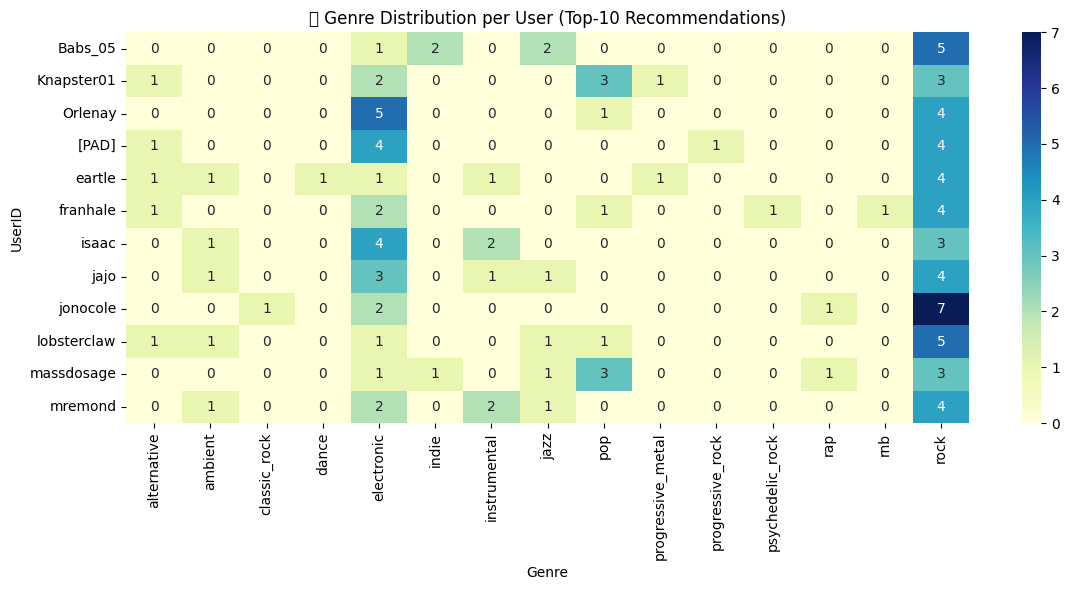

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create DataFrame if needed
rec_df = pd.DataFrame(results)
item_meta = pd.read_csv("music_item.csv")
rec_df = pd.merge(rec_df, item_meta, on='ItemID', how='left')

# Step 2: Count genre recommendations per user
genre_user_matrix = rec_df.groupby(['UserID', 'Genre']).size().unstack(fill_value=0)

# Step 3: Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(genre_user_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("🎨 Genre Distribution per User (Top-10 Recommendations)")
plt.xlabel("Genre")
plt.ylabel("UserID")
plt.tight_layout()
plt.show()


/tmp/ipython-input-25-2100308458.py:16: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


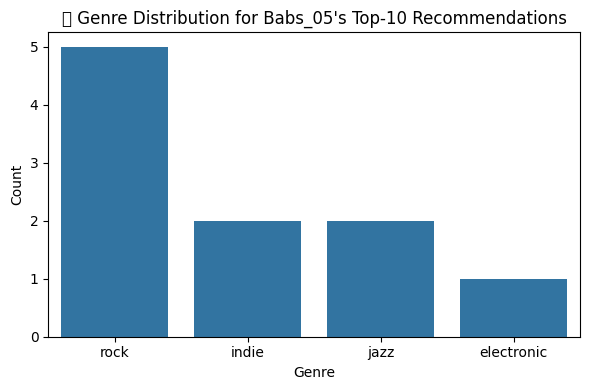

In [ ]:
target_user = "Babs_05"

# Filter recs
user_recs = rec_df[rec_df['UserID'] == target_user]

# Count genres
genre_counts = user_recs['Genre'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=genre_counts, x='Genre', y='Count')
plt.title(f"🎵 Genre Distribution for {target_user}'s Top-10 Recommendations")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


/tmp/ipython-input-26-2152515516.py:16: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


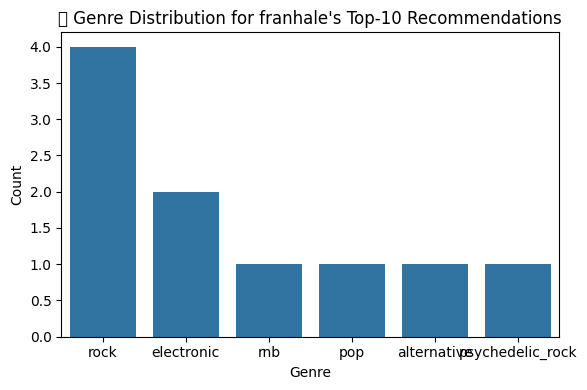

In [ ]:
target_user = "franhale"

# Filter recs
user_recs = rec_df[rec_df['UserID'] == target_user]

# Count genres
genre_counts = user_recs['Genre'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=genre_counts, x='Genre', y='Count')
plt.title(f"🎵 Genre Distribution for {target_user}'s Top-10 Recommendations")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
rec_df = pd.merge(rec_df, user_gender_df, on='UserID', how='left')
rec_df['label'] = (rec_df['Score'] > 2.5).astype(int)

# Optional preview
display(rec_df[['UserID', 'ItemID', 'Score', 'label', 'gender']].head())


,UserID,ItemID,Score,label,gender
0,[PAD],Drone Zone,0.2408,0,male
1,[PAD],Surround Me,0.2403,0,male
2,[PAD],Agent Orange,0.2379,0,male
3,[PAD],I Want You Now,0.2358,0,male
4,[PAD],Toxicity,0.2308,0,male


In [ ]:
rec_df['gender'].value_counts()


,count
gender,
male,61
female,60


In [ ]:
!pip install aif360 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
# Filter out non-real users (e.g., [PAD])
rec_df = rec_df[rec_df['UserID'] != '[PAD]'].copy()

# Convert gender to binary for AIF360
rec_df['gender_binary'] = rec_df['gender'].map({'male': 1, 'female': 0})


In [ ]:
from aif360.datasets import BinaryLabelDataset

aif_data = BinaryLabelDataset(
    df=rec_df[['Score', 'label', 'gender_binary']],
    label_names=['label'],
    protected_attribute_names=['gender_binary'],
    favorable_label=1,
    unfavorable_label=0
)


In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Define privileged and unprivileged groups
privileged_groups = [{'gender_binary': 1}]   # male
unprivileged_groups = [{'gender_binary': 0}] # female

# Binary fairness metrics (based only on labels, not predicted scores)
metric = BinaryLabelDatasetMetric(aif_data,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Statistical Parity Difference: -0.06666666666666665
Disparate Impact: 0.9


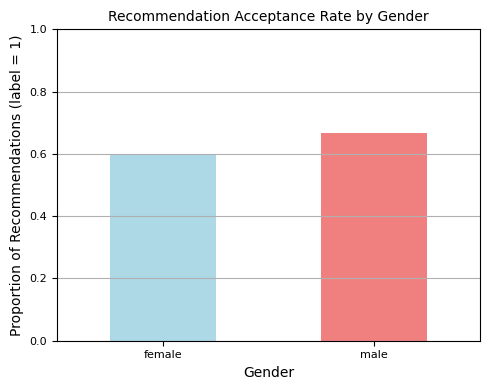

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))  # Set the size BEFORE plotting

# Mean acceptance rate (label=1) per gender
rec_df.groupby('gender')['label'].mean().plot(kind='bar', color=['lightblue', 'lightcoral'])

plt.title('Recommendation Acceptance Rate by Gender')
plt.ylabel('Proportion of Recommendations (label = 1)')
plt.xlabel('Gender')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.xticks(rotation=0, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Recommendation Acceptance Rate by Gender", fontsize=10)
plt.tight_layout()
plt.show()


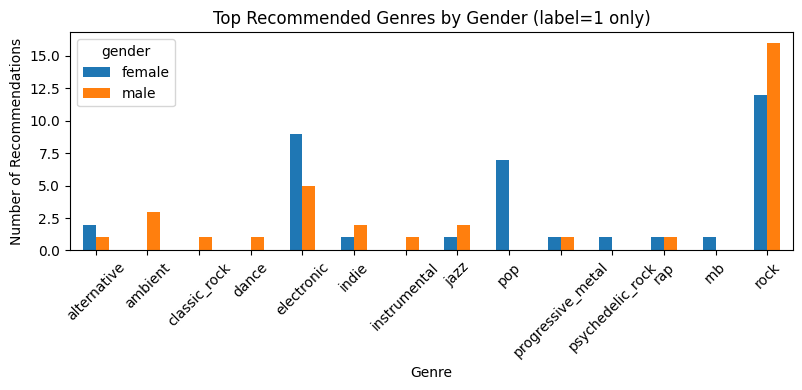

In [ ]:
genre_stats = rec_df[rec_df['label'] == 1].groupby(['gender', 'Genre']).size().unstack().fillna(0)
genre_stats.T.plot(kind='bar', figsize=(8, 4))  # Slightly bigger
plt.title('Top Recommended Genres by Gender (label=1 only)')
plt.ylabel('Number of Recommendations')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
